In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from ucimlrepo import fetch_ucirepo, list_available_datasets #Import ucidatasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_iris
from sklearn.model_selection import ValidationCurveDisplay
from matplotlib import pyplot as plt

In [17]:
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
# data  
X = car_evaluation.data.features 
y = car_evaluation.data.targets 
# metadata 
print(car_evaluation.metadata) 
  
# variable information 
print(car_evaluation.variables)

y = np.ravel(y)
X = pd.get_dummies(X)

None
{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France',

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.3, random_state=12)

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=3, max_depth=4, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))

Learning rate:  0.05
Accuracy score (training): 0.818
Accuracy score (validation): 0.767
Learning rate:  0.075
Accuracy score (training): 0.884
Accuracy score (validation): 0.838
Learning rate:  0.1
Accuracy score (training): 0.918
Accuracy score (validation): 0.881
Learning rate:  0.25
Accuracy score (training): 0.986
Accuracy score (validation): 0.950
Learning rate:  0.5
Accuracy score (training): 0.992
Accuracy score (validation): 0.973
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.979
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.977


In [29]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=.75, max_features=3, max_depth=4, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[116   0   1   0]
 [  3  18   0   4]
 [  3   0 358   0]
 [  0   0   0  16]]
Classification Report
              precision    recall  f1-score   support

         acc       0.95      0.99      0.97       117
        good       1.00      0.72      0.84        25
       unacc       1.00      0.99      0.99       361
       vgood       0.80      1.00      0.89        16

    accuracy                           0.98       519
   macro avg       0.94      0.93      0.92       519
weighted avg       0.98      0.98      0.98       519



In [19]:
def plot_learning_curve(estimator, X, y, ax=None, ylim=(0.5, 1.01), cv=None, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
              
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax.legend(loc="best")

    return plt

fig, (ax1, ax2) = plt.subplots(1, 2)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(gb_clf2, X, y, ax = ax1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))

<module 'matplotlib.pyplot' from 'C:\\Users\\Drewn\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\pyplot.py'>

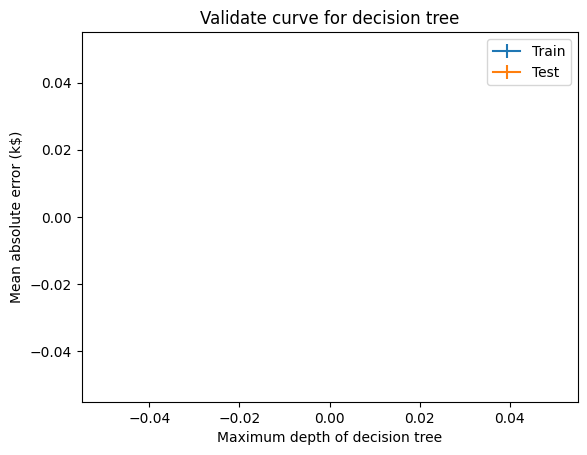

In [33]:
max_depth = np.array([1, 5, 10, 15, 20, 25])
disp = ValidationCurveDisplay.from_estimator(
    gb_clf2,
    X,
    pd.get_dummies(y),
    param_name="max_depth",
    param_range=max_depth,
    cv=cv,
    scoring="neg_mean_absolute_error",
    negate_score=True,
    std_display_style="errorbar",
    n_jobs=2,
)
_ = disp.ax_.set(
    xlabel="Maximum depth of decision tree",
    ylabel="Mean absolute error (k$)",
    title="Validate curve for decision tree",
)